In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
#import capLib as ca
#import fdulib as vdf
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl

In [3]:
import pynbody


In [4]:
sim = pynbody.load("/data/output_00041/")

/usr/local/lib/python2.7/dist-packages/pynbody/snapshot/ramses.py:374: RuntimeWarning: RamsesSnap is configured to use multiple processes, but the posix_ipc module is missing. Reverting to single thread.
  warnings.warn("RamsesSnap is configured to use multiple processes, but the posix_ipc module is missing. Reverting to single thread.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/pynbody/snapshot/ramses.py:521: UserWarning: Using field 'tform' to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher.
  warnings.warn("Using field %s to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher."%pb_name)
/usr/local/lib/python2.7/dist-packages/pynbody/util.py:627: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  f.seek(alen, 1)


In [6]:
to_mpc = sim.properties['boxsize'].in_units('Mpc')*sim.properties['h']
to_kpc = 1e3*to_mpc
print to_kpc

24954.3199405


In [7]:
#myouputInd=1
#count='00417'


vars=dict()
with open("/data/output_00041/info_00041.txt") as outinfo:
    for line in outinfo:
        print(line[:-1])
        eq_index = line.find('=')
        if eq_index == -1:
            continue
        var_name = line[:eq_index].strip()
        number = float(line[eq_index + 1:].strip())
        vars[var_name] = number
        if var_name == "unit_t":
            break   


print(vars)
print("\n\n")
aexp=vars["aexp"]
print('aexp= ',aexp)
Msunkg = 1.99844*10**30
pctocm = 3.08567758*10**18
cmtopc = 1/pctocm
unitl=vars["unit_l"]/(3.08*10**18)*pctocm
unitd=vars["unit_d"]/(pctocm/
                      (3.08*10**18))**3
unitt=vars["unit_t"]
simutokpc=unitl*vars["H0"]/pctocm/1000
simutoMsun=(unitd*unitl**3)/1000/Msunkg
unitsimutoMsunkpc3=unitd*pctocm**3/1000/Msunkg
unitsimutokms = unitl/10**5/unitt
print "unitsimutokms", unitsimutokms
print "simutokpc= ",simutokpc
print "simutoMsun= ",simutoMsun
print 'unitsimutoMsunkpc3 =',unitsimutoMsunkpc3


Halovelx=-17.99402546833644
Halovely=-50.12026991953947
Halovelz=-66.99018276193101
halovel= [Halovelx, Halovely,Halovelz]

ncpu        =         96
ndim        =          3
levelmin    =          7
levelmax    =         14
ngridmax    =    2000000
nstep_coarse=       7526

boxlen      =  0.100000000000000E+01
time        =  0.138103311333510E-04
aexp        =  0.100001372976141E+01
H0          =  0.677399978637695E+02
omega_m     =  0.308899998664856E+00
omega_l     =  0.691100001335144E+00
omega_k     =  0.000000000000000E+00
omega_b     =  0.486000000000000E-01
unit_l      =  0.113671471244248E+27
unit_d      =  0.266469940380375E-29
unit_t      =  0.454692157225212E+18
{'ndim': 3.0, 'levelmax': 14.0, 'ngridmax': 2000000.0, 'omega_m': 0.308899998664856, 'unit_t': 4.54692157225212e+17, 'unit_l': 1.13671471244248e+26, 'aexp': 1.00001372976141, 'nstep_coarse': 7526.0, 'ncpu': 96.0, 'unit_d': 2.66469940380375e-30, 'omega_b': 0.0486, 'boxlen': 1.0, 'time': 1.3810331133351e-05, 'omega_l': 0.691100001335144, 'H0': 67.7399978637695, 'levelmin': 7.0, 'omega_k': 0.0}



('aexp= ', 1.00001372976141)
unitsimutokms 2

In [3]:
class Halo:
    def __init__(self, file_path, component,**kwargs):
        simutokpc = kwargs.get('simutokpc',1.)
        simutokms = kwargs.get('simutokms',1.)
        hsml = kwargs.get('hsml',False)
        dens = kwargs.get('dens',False)        
        center = kwargs.get('center',[0,0,0])
        halo_vel = kwargs.get('halo_vel',[0.,0.,0.])
        self.comp = component
        msuntokg = 1.989e30 
        kgtoGeV = 1/1.783e-27
        kpctocm = 3.086e21
        simutoGeVcm3 = (simutoMsun*msuntokg*kgtoGeV) / (simutokpc*kpctocm)**3 
        uns = CunsIn(file_path,component,"all",False)
        ok=uns.nextFrame("") 
        ok,pos = uns.getArrayF("all","pos")
        ok, vel = uns.getArrayF("all","vel")
        if dens ==True:
            ok, rho = uns.getArrayF("all","rho")
            self.rho =  rho * simutoGeVcm3
        if hsml ==True:
            ok, self.hsml = uns.getArrayF("all","hsml")
        uns.close()
        
        ### coordinates ###
        pos = pos * simutokpc
        self.x,self.y,self.z = pos[0::3]-center[0],pos[1::3]-center[1],pos[2::3]-center[2]
        self.R = np.sqrt((self.x**2)+(self.y**2))
        self.r = np.sqrt((self.x**2)+(self.y**2)+(self.z**2))
        ### velocities ###
        vel = vel * simutokms
        self.vx,self.vy,self.vz = vel[0::3] - halo_vel[0],vel[1::3] - halo_vel[1],vel[2::3] - halo_vel[2]
        self.v = np.sqrt((self.vx**2) + (self.vy**2) + (self.vz**2))
        self.vR = (self.vx*self.x + self.vy*self.y)/ self.R
        self.vr = (self.vx*self.x + self.vy*self.y + self.vz*self.z)/ self.r
        self.vphi = (-self.vx*self.y + self.vy*self.x )/ self.R
        ### densities ### 
        
    def get_shell(self,lim_min,lim_max):
        shell_cond = (self.r<=lim_max)&(self.r>=lim_min)
        self.v_shell = self.v[shell_cond]
        self.vr_shell = self.vr[shell_cond]
        self.vR_shell = self.vR[shell_cond]
        self.vphi_shell = self.vphi[shell_cond]
        self.vz_shell = self.vz[shell_cond]
    
    def get_ring_xy(self,lim_min,lim_max, thickness):
        ringXY_cond = (self.r<=lim_max)&(self.r>=lim_min)&(abs(self.z)<=thickness)
        self.v_ringXY = self.v[ringXY_cond]
        self.vr_ringXY = self.vr[ringXY_cond]
        self.vR_ringXY = self.vR[ringXY_cond]
        self.vphi_ringXY = self.vphi[ringXY_cond]
        self.vz_ringXY = self.vz[ringXY_cond]
        self.x_ringXY = self.x[ringXY_cond]
        self.y_ringXY = self.y[ringXY_cond]
        self.z_ringXY = self.z[ringXY_cond]
        self.vx_ringXY = self.vx[ringXY_cond]
        self.vy_ringXY = self.vy[ringXY_cond]
        
    def get_ring_yz(self,lim_min,lim_max, thickness):
        ringYZ_cond = (self.r<=lim_max)&(self.r>=lim_min)&(abs(self.x)<=thickness)
        self.v_ringYZ = self.v[ringYZ_cond]
        self.vr_ringYZ = self.vr[ringYZ_cond]
        self.vR_ringYZ = self.vR[ringYZ_cond]
        self.vphi_ringYZ = self.vphi[ringYZ_cond]
        self.vz_ringYZ = self.vz[ringYZ_cond]
        
    def get_ring_zx(self,lim_min,lim_max, thickness):
        ringZX_cond = (self.r<=lim_max)&(self.r>=lim_min)&(abs(self.y)<=thickness)
        self.v_ringZX = self.v[ringZX_cond]
        self.vr_ringZX = self.vr[ringZX_cond]
        self.vR_ringZX = self.vR[ringZX_cond]
        self.vphi_ringZX = self.vphi[ringZX_cond]
        self.vz_ringZX = self.vz[ringZX_cond]
    
    def get_dens(self,lim_min,lim_max, thickness,plane="x"):
        shell_cond = (self.r<=lim_max)&(self.r>=lim_min)
        if plane == "x":
            plane_cond = (abs(self.z)<=thickness)
        elif plane == "y":
            plane_cond = (abs(self.x)<=thickness)
        elif plane == "z":
            plane_cond = (abs(self.y)<=thickness)
        else:
            plane_cond = (True)
        condition = shell_cond & plane_cond
        self.rho_ring = self.rho[condition]
        self.rho_shell = self.rho[shell_cond]

  



# Dark Matter

In [4]:
dmHALO = wkbl.Galaxy_Hound("/data/halotmp/myhalo-out417-dm-rot.dens", "all",
                  dens=True,simutokpc=simutokpc,simutokms=unitsimutokms,
                  halo_vel=halovel,hsml=True, simutoMsun=simutoMsun,
                  center = [2.08196, -0.358306, -0.595929]
                 )

In [5]:
x_shif,y_shif,z_shif = 2.08196, -0.358306, -0.595929
print np.sqrt(x_shif**2 + y_shif**2 + z_shif**2)

2.1950107071


In [6]:
contition = (dmHALO.rho==np.max(dmHALO.rho))&(dmHALO.x<10.)
nurho = dmHALO.rho[(dmHALO.r<12.)]
nux = dmHALO.x[(dmHALO.r<12.)]
nuy = dmHALO.y[(dmHALO.r<12.)]
nuz = dmHALO.z[(dmHALO.r<12.)]


print nux[np.where(nurho==np.max(nurho))][0],nuy[np.where(nurho==np.max(nurho))][0] ,nuz[np.where(nurho==np.max(nurho))][0]

-4.05312e-06 -3.8743e-07 3.57628e-07


In [7]:
msuntokg = 1.989e30 
kgtoGeV = 1/1.783e-27
kpctocm = 3.086e21
simutoGeVcm3 = (simutoMsun*msuntokg*kgtoGeV) / (simutokpc*kpctocm)**3 
print len(dmHALO.hsml)

2839680


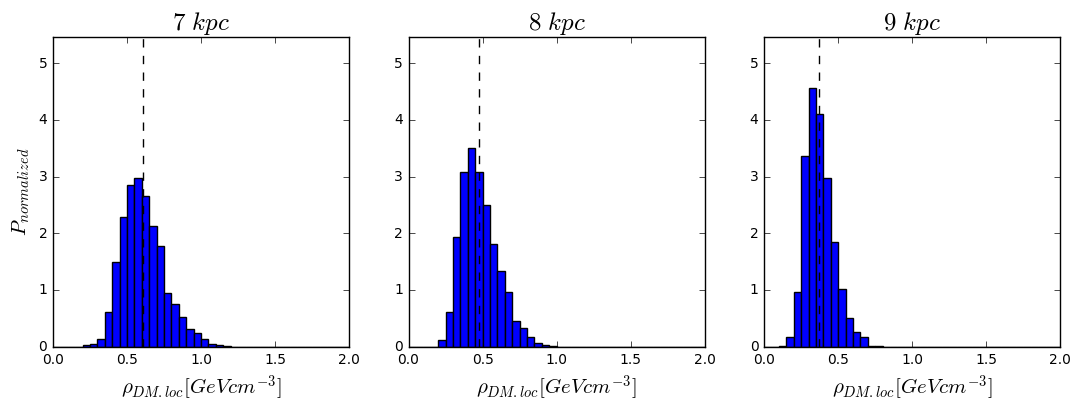

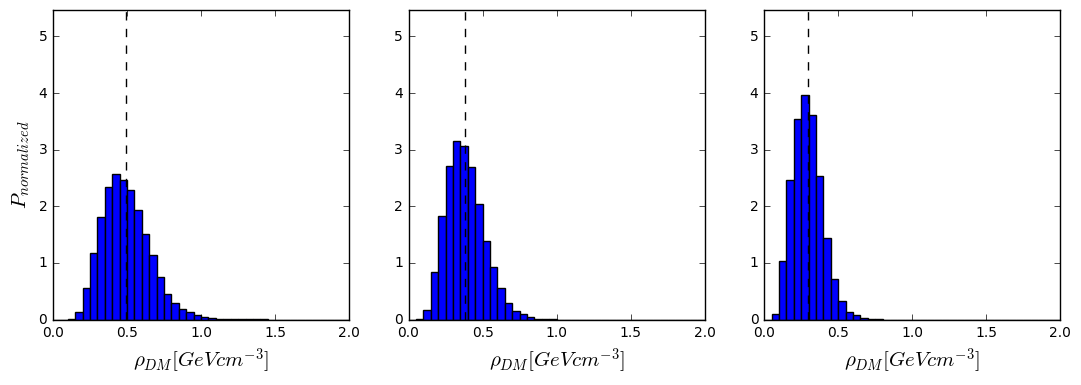

In [14]:
vertical = np.arange(0,6,0.01)
mean7 = np.array([np.mean(rho7) for i in vertical])
mean8 = np.array([np.mean(rho8) for i in vertical])
mean9 = np.array([np.mean(rho9) for i in vertical])
means7 = np.array([np.mean(rhos7) for i in vertical])
means8 = np.array([np.mean(rhos8) for i in vertical])
means9 = np.array([np.mean(rhos9) for i in vertical])
rho_array = np.arange(0,4.0,0.05)


hist7 = np.histogram(rho7,bins=rho_array, normed=True)
hist8 = np.histogram(rho8,bins=rho_array, normed=True)
hist9 = np.histogram(rho9,bins=rho_array, normed=True)

fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize = [13,4])
ax.set_ylim([0,np.max(hist9[0])*1.2])
ax.set_xlim([0,2])
ax1.set_ylim([0,np.max(hist9[0])*1.2])
ax1.set_xlim([0,2])
ax2.set_ylim([0,np.max(hist9[0])*1.2])
ax2.set_xlim([0,2])
ax.set_title(r'$7\,\, kpc$', fontsize=18)
ax1.set_title(r'$8\,\, kpc$', fontsize=18)
ax2.set_title(r'$9\,\, kpc$', fontsize=18)
ax.set_ylabel(r'$P_{normalized}$',fontsize=15)
ax.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax1.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax2.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax.bar(hist7[1][:-1],hist7[0],width=0.05)
ax1.bar(hist8[1][:-1],hist8[0],width=0.05)
ax2.bar(hist9[1][:-1],hist9[0],width=0.05)
ax.plot(mean7,vertical,'k--')
ax1.plot(mean8,vertical,'k--')
ax2.plot(mean9,vertical,'k--')

hists7 = np.histogram(rhos7,bins=rho_array, normed=True)

hists8 = np.histogram(rhos8,bins=rho_array, normed=True)
hists9 = np.histogram(rhos9,bins=rho_array, normed=True)

fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize = [13,4])
ax.set_ylabel(r'$P_{normalized}$',fontsize=15)
ax.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
ax1.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
ax2.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
ax.set_ylim([0,np.max(hist9[0])*1.2])
ax.set_xlim([0,2])
ax1.set_ylim([0,np.max(hist9[0])*1.2])
ax1.set_xlim([0,2])
ax2.set_ylim([0,np.max(hist9[0])*1.2])
ax2.set_xlim([0,2])
ax.bar(hists7[1][:-1],hists7[0],width=0.05)
ax1.bar(hists8[1][:-1],hists8[0],width=0.05)

ax2.bar(hists9[1][:-1],hists9[0],width=0.05)
ax.plot(means7,vertical,'k--')
ax1.plot(means8,vertical,'k--')
ax2.plot(means9,vertical,'k--')

In [15]:
dmHALO.get_dens(6.5,7.5,0.5)
rhos7 = dmHALO.rho_shell
rhos7 =  rhos7 
rho7 = dmHALO.rho_ring
rho7 =  rho7
dmHALO.get_dens(7.5,8.5,0.5)
rhos8 = dmHALO.rho_shell
rhos8 =  rhos8
rho8 = dmHALO.rho_ring
rho8 =  rho8
dmHALO.get_dens(8.5,9.5,0.5)
rhos9 = dmHALO.rho_shell
rhos9 =  rhos9 
rho9 = dmHALO.rho_ring
rho9 =  rho9

In [16]:

rho = dmHALO.rho 
x,y,z = dmHALO.x, dmHALO.y, dmHALO.z
rxy , rxz, ryz = sqrt(x**2 + y**2), sqrt(x**2 + z**2), sqrt(z**2 + y**2) 

print np.min(rxy[~np.isnan(rxy)]),len(rxy),len(rxz),len(ryz)
print len(rho),len(x),len(y),len(z)

4.07159e-06 2839680 2839680 2839680
2839680 2839680 2839680 2839680


In [17]:
result = rho[(rxy<=8.5)&(rxy>=7.5)&(abs(z-5.)<1.)]
print np.mean(result[~np.isnan(result)])

0.272285


In [18]:
def surdensitexy(zval):
    result = rho[(abs(rxy-8.)<1.)&(abs(z-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

def surdensitexz(zval):
    result = rho[(abs(rxz-8.)<1.)&(abs(y-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

def surdensiteyz(zval):
    result = rho[(abs(ryz-8.)<1.)&(abs(x-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

get_xy = np.vectorize(surdensitexy)
get_xz = np.vectorize(surdensitexz)
get_yz = np.vectorize(surdensiteyz)

z_array = np.arange(-15,16,1.)
res = get_xy(z_array)
res2 = get_xz(z_array)
res3 = get_yz(z_array)


    
    

In [19]:
def ratio(R,plane):
    dmHALO.get_dens(R-.5,R+.5,0.5,plane=plane)
    ring, shell = np.mean(dmHALO.rho_ring), np.mean(dmHALO.rho_shell)

    return ring /shell
rationaicer = np.vectorize(ratio)
R_array= np.arange(0,45,2)
ratio_resxy = rationaicer(R_array,"x")
ratio_resyz = rationaicer(R_array,"y")    
ratio_resxz = rationaicer(R_array,"z")


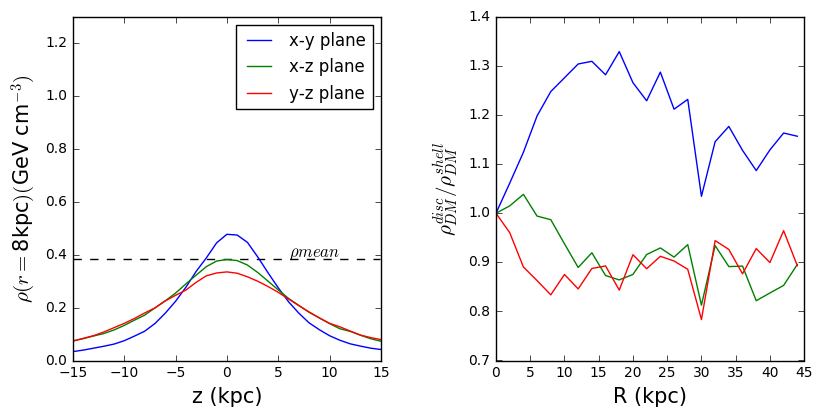

In [20]:

horizontal = np.arange(-15,15,0.1)
mean= np.array([np.mean(rhos8) for i in horizontal])

fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
fig.tight_layout(w_pad=5.5)
ax.set_ylim([0,1.3])
ax.set_xlabel("z (kpc)",fontsize=15)
ax.set_ylabel(r'$\rho (r=$8kpc$)($GeV cm$^{-3})$',fontsize=15)
ax.text(6,np.mean(rhos8)+0.01,r'$\rho mean$',size=12)
ax.plot(horizontal,mean,'k--')
ax.plot(z_array,res,label = "x-y plane")
ax.plot(z_array,res2,label = "x-z plane")
ax.plot(z_array,res3,label = "y-z plane")
legend = ax.legend(loc='upper right', shadow=False)

ax1.set_xlabel("R (kpc)",fontsize=15)
ax1.set_ylabel(r'$\rho_{DM} ^{disc} / \rho_{DM} ^{shell} $',fontsize=15)
ax1.plot(R_array,ratio_resxy)
ax1.plot(R_array,ratio_resxz)
ax1.plot(R_array,ratio_resyz)


# Stars

In [22]:
starsHALO = wkbl.Galaxy_Hound("/data/halotmp/myhalo-out417-st-rot.age.dens", "all",
              dens=True,simutokpc=simutokpc,simutokms=unitsimutokms,
              halo_vel=halovel,hsml=True,
                  center = [2.08196, -0.358306, -0.595929]
                 )

starsHALO.get_ring_xy(7.5,8.5,.5)


In [23]:
bin_size=5.
v_str_array = np.arange(-400,400,bin_size)
vr_st_hist = np.histogram(starsHALO.vR_ringXY,
                          bins=v_str_array,normed=True)
vphi_st_hist = np.histogram(starsHALO.vphi_ringXY,
                          bins=v_str_array,normed=True)
vz_st_hist = np.histogram(starsHALO.vz_ringXY,
                          bins=v_str_array,normed=True)

<Container object of 159 artists>

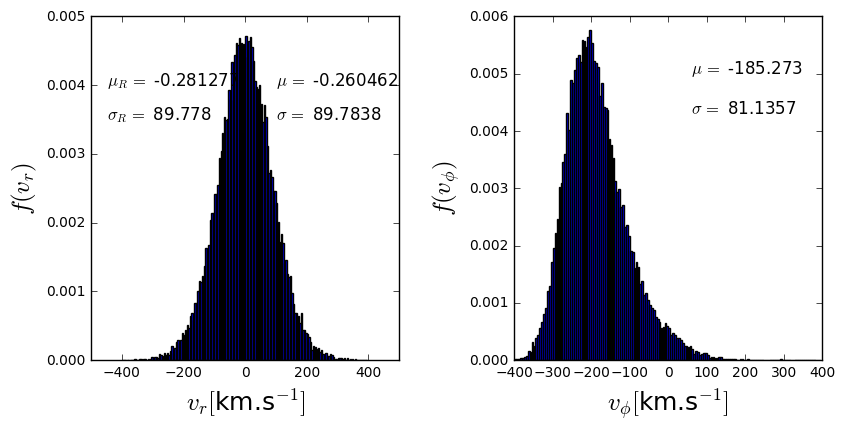

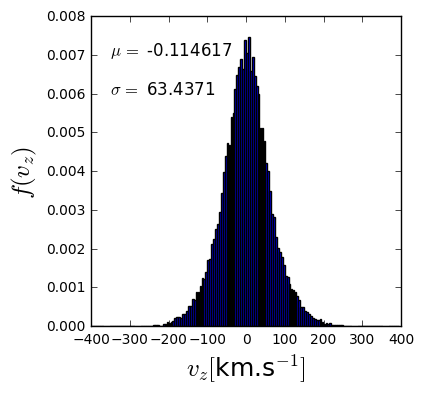

In [24]:
fig, (ax,ax1)=plt.subplots(1,2,figsize=[8,4])
fig.tight_layout(w_pad=5.5)
ax.set_xlim([-500,500])
ax.set_ylim([0,.005])
ax.set_xlabel(r'$v_r [$km.s$^{-1}]$',fontsize=18)
ax.set_ylabel(r'$f(v_r)$',fontsize=18)
ax.text(-450,0.004,r'$\mu_R\,=$ '+str(np.mean(starsHALO.vR_ringXY)),size=12)
ax.text(-450,0.0035,r'$\sigma_R\,=$ '+str(sqrt(np.var(starsHALO.vR_ringXY))),
        size=12)
ax.text(100,0.004,r'$\mu\,=$ '+str(np.mean(starsHALO.vr_ringXY)),size=12)
ax.text(100,0.0035,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vr_ringXY))),
        size=12)
ax1.text(60,0.005,r'$\mu\,=$ '+str(np.mean(starsHALO.vphi_ringXY)),size=12)
ax1.text(60,0.0043,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vphi_ringXY))),
        size=12)
ax1.set_xlabel(r'$v_{\phi} [$km.s$^{-1}]$',fontsize=18)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=18)
ax.bar(vr_st_hist[1][:-1],vr_st_hist[0],width=bin_size*9./10.)
ax1.bar(vphi_st_hist[1][:-1],vphi_st_hist[0],width=bin_size*9./10.)
fig,ax = plt.subplots(figsize=[4,4])
ax.set_xlabel(r'$v_z [$km.s$^{-1}]$',fontsize=18)
ax.set_ylabel(r'$f(v_z)$',fontsize=18)
ax.text(-350,0.007,r'$\mu\,=$ '+str(np.mean(starsHALO.vz_ringXY)),size=12)
ax.text(-350,0.006,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vz_ringXY))),
        size=12)
ax.bar(vz_st_hist[1][:-1],vz_st_hist[0],width=bin_size*9./10.)

In [25]:
dmHALO.get_ring_xy(7.5,8.5,.5)

In [26]:

dmindex = np.random.randint(0,high=len(dmHALO.x_ringXY),size=1000)
xdm = dmHALO.x_ringXY[dmindex]

ydm = dmHALO.y_ringXY[dmindex]
vxdm = dmHALO.vx_ringXY[dmindex]/120.
vydm = dmHALO.vy_ringXY[dmindex]/120.
print len(ydm)

1000


In [27]:

dmindex = np.random.randint(0,high=len(starsHALO.vR_ringXY),size=843)
dmindex =np.random.choice(len(starsHALO.vR_ringXY),1004)
xstr = starsHALO.x_ringXY[dmindex]
ystr = starsHALO.y_ringXY[dmindex]
vxstr = starsHALO.vx_ringXY[dmindex]/150.
vystr = starsHALO.vy_ringXY[dmindex]/150.

print len(dmHALO.vr_ringXY)
print len(starsHALO.vr_ringXY)

2727
32850


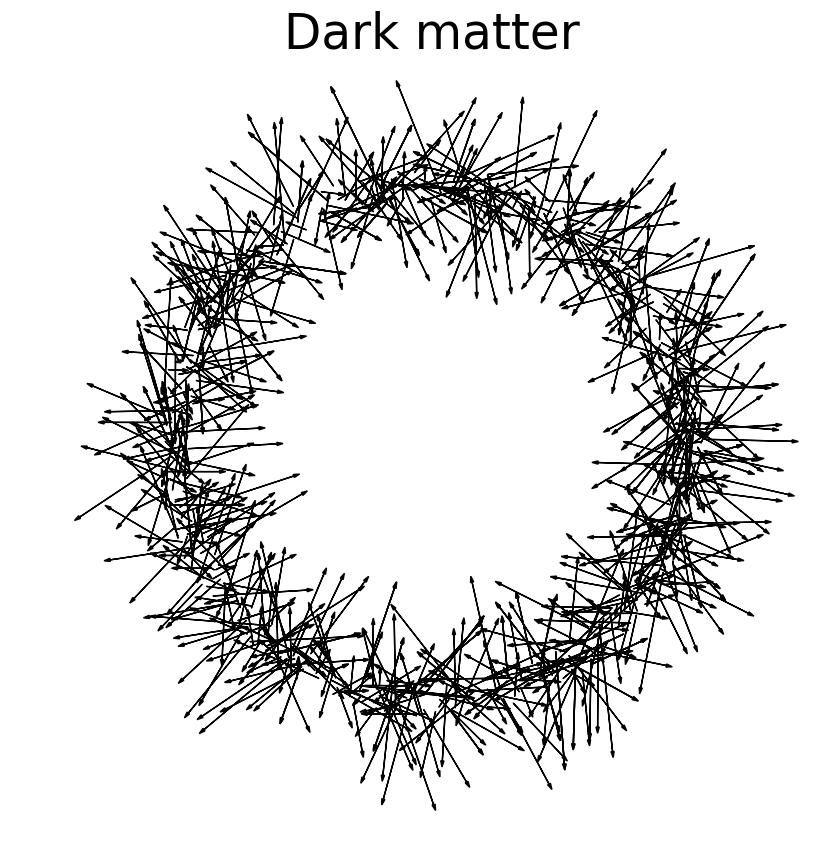

In [28]:
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])
plt.axis('off')
ax.set_title("Dark matter",fontsize=35)

for i in range(0,len(xdm)):
    ax.arrow(xdm[i], ydm[i], vxdm[i], vydm[i], head_width=0.1, head_length=.19, fc='k', ec='k')


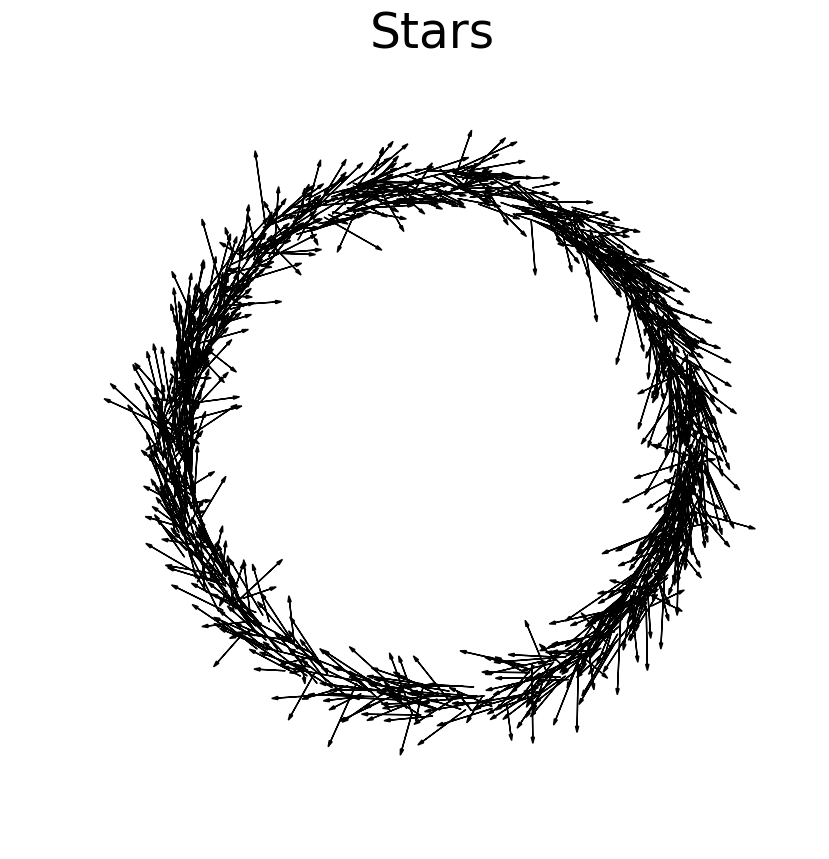

In [29]:
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])
plt.axis('off')
ax.set_title("Stars",fontsize=35)
for i in range(0,len(xstr)):
    ax.arrow(xstr[i],ystr[i],vxstr[i],vystr[i],
             head_width=0.1, head_length=.19, fc='k', ec='k')


In [30]:
dmHALO.get_shell(7.5,8.5)

In [31]:
#### ring hist
bin_array = np.arange(-500,500,50)
bin_array_mod = np.arange(0,550,20)
vR_Hist_ring = np.histogram(dmHALO.vR_ringXY,bins=bin_array,normed=1)
vphi_Hist_ring = np.histogram(dmHALO.vphi_ringXY,bins=bin_array,normed=1)
vz_Hist_ring = np.histogram(dmHALO.vz_ringXY,bins=bin_array,normed=1)
vmod_Hist_ring = np.histogram(dmHALO.v_ringXY,bins=bin_array_mod,normed=1)

#### shell hist
bin_array = np.arange(-600,600,20)
bin_array2 = np.arange(0,600,10)
vR_Hist_shell = np.histogram(dmHALO.vR_shell,bins=bin_array,normed=1)
vphi_Hist_shell = np.histogram(dmHALO.vphi_shell,bins=bin_array,normed=1)
vz_Hist_shell = np.histogram(dmHALO.vz_shell,bins=bin_array,normed=1)
vmod_Hist_shell = np.histogram(dmHALO.v_shell,bins=bin_array2,normed=1)

In [36]:
def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)

def myChi2(obs,exp,dof):
    return np.sum((obs-exp)**2/exp/dof,dtype=np.float64)

def myGenGaussian(x,mu,v0,alpha):
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myGenMaxwellian(x,v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def myMaxwellian(x,v0):
    alpha = 1.
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def maosDistribution(x,v0,p):
    v_esc =541.
    term = ((v_esc**2) - (x**2))**p
    if x < v_esc and x > 0: 
        return (x**2) * np.exp(-x/v0) * term
    else:
        return 0
    
    
#############################################################
#===========================================================#
##################### FITTING SECTION #######################
#===========================================================#
#############################################################


class MyGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200):
        alpha = 1.
        n = 2 * v0 *gamma(1+(1/(2*alpha)))
        return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
        
class MyDoubleGaussianModel(FunctionModel1DAuto):
    def f(self,x,frac=0.5,v01=100,mu2=.1,v02=200):
        return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)
    

class MyGenGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200.,alpha=1.3):
        n = 2. * v0 * gamma(1.+(1./(2*alpha)))
        return (1./n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
    
class MyGenMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=300.,alpha=1.5):
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MyMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=250.):
        alpha = 1.
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MaoModel(FunctionModel1DAuto):
    def f(self,x,v0=300.,p=2.):
        v_esc =541.
        term = ((v_esc**2) - (x**2))**p
        return (x**2) * np.exp(-x/v0) * term
#        return (x**2) * np.exp(-x/v0) * term

def myChi2(obs, expected):
    return np.sum((obs-expected)**2/expected)

### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_G_fit = myG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_G_fit = myG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])

### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_ring[1][:-1],vz_Hist_ring[0])

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Mao



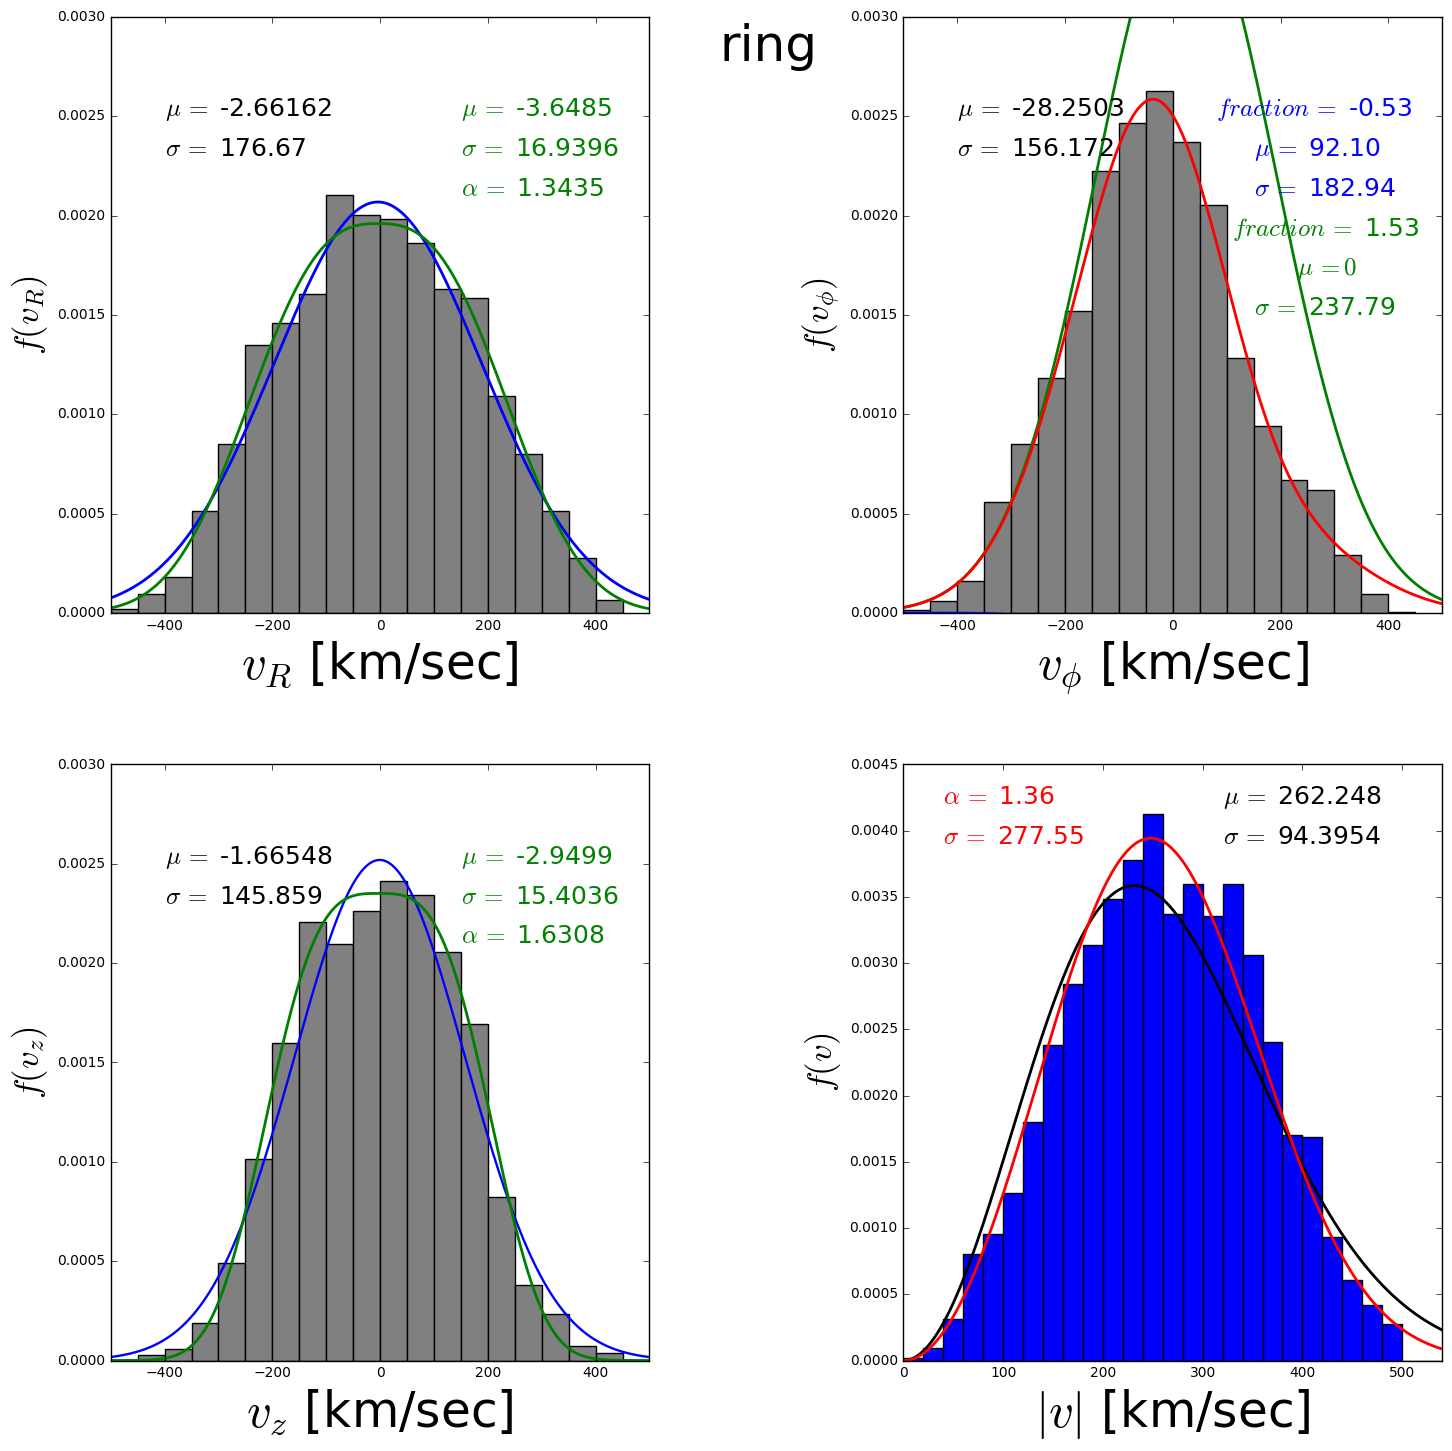

In [37]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
fig.tight_layout(h_pad=8.,w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("ring", size=36)
fig.tight_layout(w_pad=15.5, h_pad=9.0)

ax.set_xlabel(r'$v_R$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_R)$',fontsize=25)
ax.set_xlim([-500,500])
ax.set_ylim([0,0.003])
bin_array = np.arange(-500,500,50)
bin_array2 = np.arange(-500,500,10)


ax.bar(vR_Hist_ring[1][:-1],vR_Hist_ring[0], width=50, color='gray')

ax.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vR_ringXY)),size=18)
ax.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vR_ringXY))),
        size=18)

ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)
ax1.set_xlim([-500,500])
ax1.set_ylim([0,0.003])

ax1.bar(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0], width=50,
        color='gray')
ax1.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vphi_ringXY)),size=18)
ax1.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vphi_ringXY))),
        size=18)

ax2.set_xlim([-500,500])
ax2.set_ylim([0,0.003])
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)

ax3.set_xlim([0,540])
ax3.set_ylim([0,0.0045])

ax2.bar(vz_Hist_ring[1][:-1],vz_Hist_ring[0], width=50,
        color='gray')
ax2.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vz_ringXY)),size=18)
ax2.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vz_ringXY))),
        size=18)

bin_array_mod = np.arange(0,550,20)

ax3.bar(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0], width=20,
        color='blue')

ax3.text(320,0.0042,r'$\mu\,=$ '+str(np.mean(dmHALO.v_ringXY)),size=18)
ax3.text(320,0.0039,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.v_ringXY))),
        size=18)

############ plot fits
v_test = np.arange(-525,525)
ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

ax.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(R_GG_fit[0])),size=18,color="green")
ax.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(R_GG_fit[1]))),
        size=18,color="green")
ax.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(R_GG_fit[2])),
        size=18,color="green")


ax1.plot(v_test+25,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test+25, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
ax1.plot(v_test+25, myDoubleGaussianFunc(v_test,phi_DG_fit[0],
                                      phi_DG_fit[1],phi_DG_fit[2],
                                      phi_DG_fit[3]),linewidth = 2)

ax1.text(80,0.0025,r'$fraction\,=$ '+str('{0:.2f}'.format(phi_DG_fit[0])),
        size=18,color="blue")
ax1.text(150,0.0023,r'$\mu\,=$ '+str('{0:.2f}'.format((phi_DG_fit[2]))),
        size=18,color="blue")
ax1.text(150,0.0021,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[1])),
        size=18,color="blue")
ax1.text(110,0.0019,r'$fraction\,=$ '+str('{0:.2f}'.format(1-phi_DG_fit[0])),
        size=18,color="green")
ax1.text(230,0.0017,r'$\mu\,=0$ ',
        size=18,color="green")
ax1.text(150,0.0015,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[3])),
        size=18,color="green")


ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

ax2.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(z_GG_fit[0])),size=18,color="green")
ax2.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(z_GG_fit[1]))),
        size=18,color="green")
ax2.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(z_GG_fit[2])),
        size=18,color="green")

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)

ax3.text(40,0.0042,r'$\alpha\,=$ '+str('{0:.2f}'.format((v_GM_fit[1]))),
        size=18,color="red")
ax3.text(40,0.0039,r'$\sigma\,=$ '+str('{0:.2f}'.format(v_GM_fit[0])),
        size=18,color="red")

In [38]:
### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_G_fit = myG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_G_fit = myG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])


### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])
print phi_DG_fit

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Mao

[ -2.26212299e-01   1.45171616e+02   1.26978312e+02   2.27470251e+02]


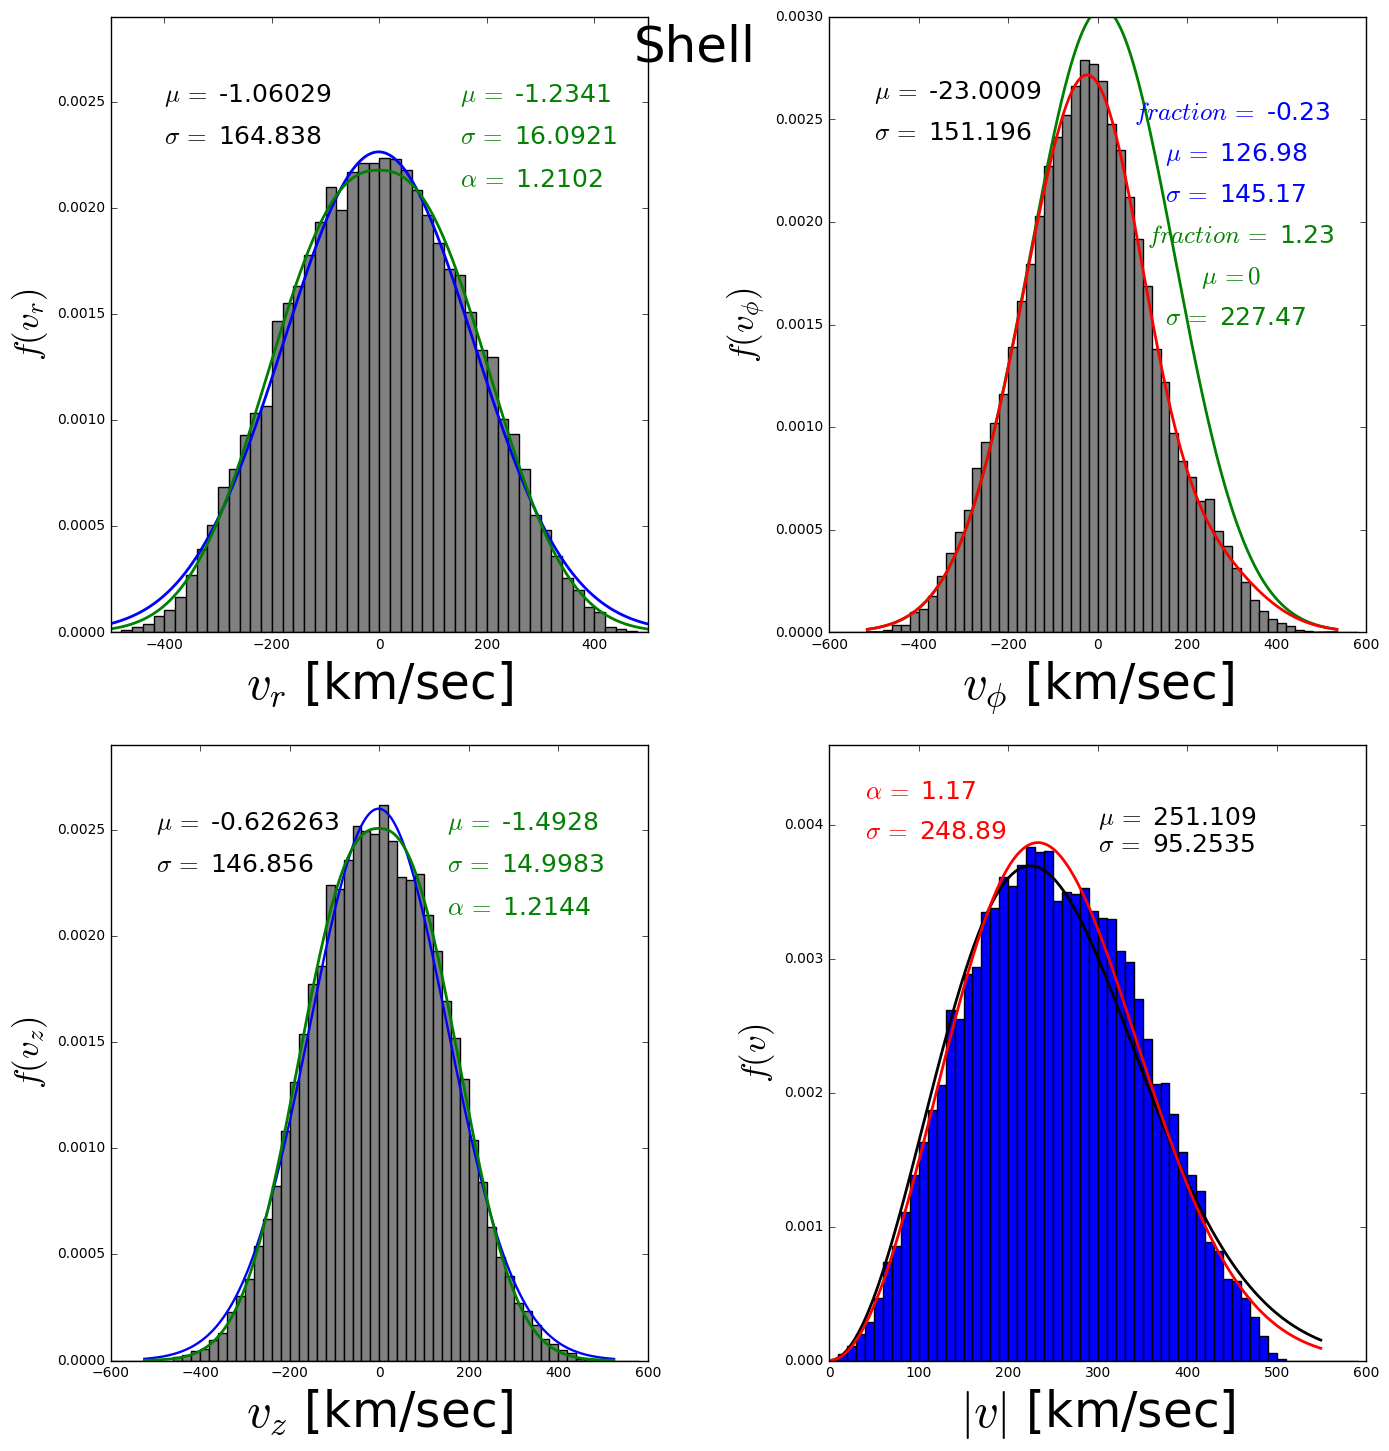

In [35]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
fig.tight_layout(w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("Shell", size=36)
ax.set_xlabel(r'$v_r$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_r)$',fontsize=25)
ax.set_xlim([-500,500])
ax3.set_xlim([0,600])
ax.set_ylim([0,29e-4])
ax1.set_ylim([0,30e-4])
ax2.set_ylim([0,29e-4])
ax3.set_ylim([0,46e-4])

bin_array = np.arange(-600,600,20)

ax.bar(vR_Hist_shell[1][:-1],vR_Hist_shell[0], width=20,
        color='gray')
ax.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vR_shell)),size=18)
ax.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vR_shell))),
        size=18)

#ax.plot(testx,myDoubleGaussianFunc(testx,popt[0],popt[1],popt[2],popt[3]))
ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)

fig.tight_layout(w_pad=5.5, h_pad=2.0)

ax1.bar(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0], width=20,
        color='gray')

ax1.text(-500,0.0026,r'$\mu\,=$ '+str(np.mean(dmHALO.vphi_shell)),size=18)
ax1.text(-500,0.0024,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vphi_shell))),
        size=18)
#fig, (ax,ax1) = plt.subplots(1,2,figsize=[13,6])
#plt.tight_layout(w_pad=5.5, h_pad=1.0)
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)


ax2.bar(vz_Hist_shell[1][:-1],vz_Hist_shell[0], width=20,
        color='gray')
ax2.text(-500,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vz_shell)),size=18)
ax2.text(-500,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vz_shell))),
        size=18)
bin_array2 = np.arange(0,600,10)

ax3.bar(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0], width=10,
        color='blue')
ax3.text(300,0.004,r'$\mu\,=$ '+str(np.mean(dmHALO.v_shell)),size=18)
ax3.text(300,0.0038,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.v_shell))),
        size=18)



v_test = np.arange(-525,525)
ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

ax.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(R_GG_fit[0])),size=18,color="green")
ax.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(R_GG_fit[1]))),
        size=18,color="green")
ax.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(R_GG_fit[2])),
        size=18,color="green")


ax1.plot(v_test+10,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test+10, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
ax1.plot(v_test+10, myDoubleGaussianFunc(v_test,phi_DG_fit[0],
                                      phi_DG_fit[1],phi_DG_fit[2],
                                      phi_DG_fit[3]),linewidth = 2)

ax1.text(80,0.0025,r'$fraction\,=$ '+str('{0:.2f}'.format(phi_DG_fit[0])),
        size=18,color="blue")
ax1.text(150,0.0023,r'$\mu\,=$ '+str('{0:.2f}'.format((phi_DG_fit[2]))),
        size=18,color="blue")
ax1.text(150,0.0021,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[1])),
        size=18,color="blue")
ax1.text(110,0.0019,r'$fraction\,=$ '+str('{0:.2f}'.format(1-phi_DG_fit[0])),
        size=18,color="green")
ax1.text(230,0.0017,r'$\mu\,=0$ ',
        size=18,color="green")
ax1.text(150,0.0015,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[3])),
        size=18,color="green")


ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

ax2.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(z_GG_fit[0])),size=18,color="green")
ax2.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(z_GG_fit[1]))),
        size=18,color="green")
ax2.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(z_GG_fit[2])),
        size=18,color="green")

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)

ax3.text(40,0.0042,r'$\alpha\,=$ '+str('{0:.2f}'.format((v_GM_fit[1]))),
        size=18,color="red")
ax3.text(40,0.0039,r'$\sigma\,=$ '+str('{0:.2f}'.format(v_GM_fit[0])),
        size=18,color="red")

In [ ]:
print "dm",len(dmHALO.vr_ringXY)
print "st",len(starsHALO.vr_ringXY)

In [ ]:
dmHALO.get_ring_xy(7.,9.,1)
print len(dmHALO.vr_ringXY)

